In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import warnings
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
warnings.filterwarnings('ignore')

In [27]:
#特征处理

def group_feature(df, key, target, aggs):   
    agg_dict = {}
    for ag in aggs:
        agg_dict[f'{target}_{ag}'] = ag
    print(agg_dict)
    t = df.groupby(key)[target].agg(agg_dict).reset_index()
    return t

#求mode
def feature_mode(df,train,key,attrs):
    for attr in attrs:
        print("求",attr,"的众数")
        t=df.where(df[attr]>0).groupby(key)[attr].agg(lambda x: x.value_counts().index[0]).reset_index()
        train = pd.merge(train, t, on='ship', how='left')
    return train

#求相关系数
def feature_corr(df,train,key,x,y):
    print("求",x,"与",y,"的pearson系数")
    
    t=df.groupby(key)[[x,y]].corr().iloc[0::2,-1].reset_index()
    t.columns=['ship','temp',x+'_corr'] 
    #t.drop(labels='temp', axis=1)
    #print(type(t))
    train=pd.merge(train, t, on='ship', how='left') 
    return train

#求峰值kurt
def feature_kurt(df,train,key,attrs):
    def kurt(x):
        kurts = x.kurt(axis=0)
        return kurts # Series的参数为Series，则会变为DataFrame，且参数变为列
    
    for attr in attrs:
        t= df.groupby(key)[attr].apply(kurt).reset_index()
        t.columns=['ship',attr+'_kurt'] 
        #print(t.head())
        train = pd.merge(train, t, on='ship', how='left')
        #print(train.head())
    return train

def extract_feature(df, train):
    t = group_feature(df, 'ship','x',['max','min','mean','std','skew','sum'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','y',['max','min','mean','std','skew','sum'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','v',['max','mean','std','skew','sum'])#'min',
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','d',['max','min','mean','std','skew','sum'])#'max'
    train = pd.merge(train, t, on='ship', how='left')
    t=df.where(df['v']>0).groupby('ship')['v'].apply(np.min).reset_index()#v_min
    t.columns=['ship','v_min'] 
    train = pd.merge(train, t, on='ship', how='left')
    
    train['x_max_x_min'] = train['x_max'] - train['x_min']
    train['y_max_y_min'] = train['y_max'] - train['y_min']
    train['y_max_x_min'] = train['y_max'] - train['x_min']
    train['x_max_y_min'] = train['x_max'] - train['y_min']
    train['slope'] = train['y_max_y_min'] / np.where(train['x_max_x_min']==0, 0.001, train['x_max_x_min'])
    train['area'] = train['x_max_x_min'] * train['y_max_y_min']
    
    #求四分位数
    t=df.where(df['v']>0).groupby('ship')['v'].quantile(0.25).reset_index()#v_0.25
    t.columns=['ship','v_0.25'] 
    train = pd.merge(train, t, on='ship', how='left')
    t=df.where(df['v']>0).groupby('ship')['v'].quantile(0.75).reset_index()#v_0.75
    t.columns=['ship','v_0.75'] 
    train = pd.merge(train, t, on='ship', how='left')
    t=df.where(df['d']>0).groupby('ship')['d'].quantile(0.75).reset_index()#d_0.75
    t.columns=['ship','d_0.75'] 
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','v_diff',['max','min','mean','std','skew'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','d_diff',['max','min','mean','std','skew'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','x_move_a',['max','min','mean','std','skew'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','y_move_a',['max','min','mean','std','skew'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','distance_v',['max','min','mean','std','skew'])
    train = pd.merge(train, t, on='ship', how='left')
   
    #求众数
    train=feature_mode(df,train,'ship',['x','y','v','d','hour'])#,'x_move','y_move','distance','v_diff','d_diff'
    
    #求相关系数
    train=feature_corr(df,train,'ship','x','y')#经度、纬度相关系数
    train=feature_corr(df,train,'ship','v','d')#航速、航向相关系数
    train=feature_corr(df,train,'ship','x_move_a','y_move_a')#经度、纬度差分相关系数
    train=feature_corr(df,train,'ship','v_diff','d_diff')#航速、航向差分相关系数
    #train=feature_corr(df,train,'ship','x','hour')#经度、时间相关系数
    #train=feature_corr(df,train,'ship','v','hour')#航速、时间相关系数
    #train=feature_corr(df,train,'ship','x_move','hour')#经度差分、时间相关系数
    #train=feature_corr(df,train,'ship','v_diff','hour')#航速差分、时间相关系数
    #train=feature_corr(df,train,'ship','y','hour')#纬度、时间相关系数
    #train=feature_corr(df,train,'ship','d','hour')#航向、时间相关系数
    #train=feature_corr(df,train,'ship','y_move','hour')#纬度差分、时间相关系数
    #train=feature_corr(df,train,'ship','d_diff','hour')#航向差分、时间差分相关系数
    
    #求峰值
    train=feature_kurt(df,train,'ship',['x','y','v','d','hour','x_move_a','y_move_a','distance_v','v_diff','d_diff'])
    
    return train

    
def data_preprocess(data):
    df=data.copy()
    df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
    df['hour'] = df['time'].dt.hour
    df['time_diff']=df['time']-df.groupby('ship')['time'].shift(-1)
    df['second_diff']=df['time_diff'].dt.seconds
    df=df.dropna()
    df['x_move']=df['x']-df.groupby('ship')['x'].shift(-1)
    df['y_move']=df['y']-df.groupby('ship')['y'].shift(-1)
    df['v_diff']=(df['v']-df.groupby('ship')['v'].shift(-1))/df['second_diff']
    df['d_diff']=(df['d']-df.groupby('ship')['d'].shift(-1))/df['second_diff']
    df=df.dropna()
    df['x_move_a']=(df['x_move'])/df['second_diff']
    df['y_move_a']=(df['y_move'])/df['second_diff']
    df=df[(df['v']!=0) & (df['v']<=15)]
    df=df[(df['second_diff']>=100)]#怎么剔除second_diff有异常的数据是个问题
    
    df['distance_v']=np.sqrt(np.square(df['x_move'])+np.square(df['y_move']))/df['second_diff']
    #ship_index_count=df.groupby('ship')['x'].count().reset_index()
    #ship_index=ship_index_count[ship_index_count.values>10]
    #df=pd.merge(df,ship_index,left_on='ship',right_on='ship',how='left').drop('x_y',axis=1).rename(columns={'x_x':'x'})
    print(df.columns)
    return df





In [31]:
train= pd.read_hdf('E:/Msstudy/tianchi/smart_sea_active/input/train.h5')

In [32]:
test= pd.read_hdf('E:/Msstudy/tianchi/smart_sea_active/input/test.h5')

In [33]:
train=data_preprocess(train)

Index(['ship', 'x', 'y', 'v', 'd', 'time', 'type', 'hour', 'time_diff',
       'second_diff', 'x_move', 'y_move', 'v_diff', 'd_diff', 'x_move_a',
       'y_move_a', 'distance_v'],
      dtype='object')


In [34]:
train.head()

,ship,x,y,v,d,time,type,hour,time_diff,second_diff,x_move,y_move,v_diff,d_diff,x_move_a,y_move_a,distance_v
0,0,6.152038e+06,5.124873e+06,2.59,102,1900-11-10 11:58:19,拖网,11,00:10:00,600.0,808.914660,-344.632139,-0.000183,-0.018333,1.348191,-0.574387,1.465449
1,0,6.151230e+06,5.125218e+06,2.70,113,1900-11-10 11:48:19,拖网,11,00:10:00,600.0,808.872353,-344.699932,0.000000,-0.005000,1.348121,-0.574500,1.465428
2,0,6.150421e+06,5.125563e+06,2.70,116,1900-11-10 11:38:19,拖网,11,00:10:00,600.0,808.830024,-344.767718,-0.000983,0.035000,1.348050,-0.574613,1.465407
3,0,6.149612e+06,5.125907e+06,3.29,95,1900-11-10 11:28:19,拖网,11,00:10:00,600.0,808.787673,-344.835498,0.000183,-0.021667,1.347979,-0.574726,1.465387
4,0,6.148803e+06,5.126252e+06,3.18,108,1900-11-10 11:18:19,拖网,11,00:10:00,600.0,805.325842,-562.955816,0.000350,-0.035000,1.342210,-0.938260,1.637638


In [35]:
train.describe()

,ship,x,y,v,d,hour,time_diff,second_diff,x_move,y_move,v_diff,d_diff,x_move_a,y_move_a,distance_v
count,2.091445e+06,2.091445e+06,2.091445e+06,2.091445e+06,2.091445e+06,2.091445e+06,2091445,2.091445e+06,2.091445e+06,2.091445e+06,2.091445e+06,2.091445e+06,2.091445e+06,2.091445e+06,2.091445e+06
mean,3.495540e+03,6.291654e+06,5.276567e+06,2.241958e+00,1.316230e+02,1.158607e+01,0 days 00:11:09.982534,6.696107e+02,-6.857178e+00,-7.174262e+00,3.526911e-05,4.087463e-04,-1.196459e-02,-1.364413e-02,1.191244e+00
std,2.019114e+03,2.838869e+05,2.632582e+05,2.548265e+00,1.155378e+02,6.956924e+00,0 days 00:08:43.539451,4.630465e+02,5.099639e+03,5.857258e+03,2.590517e-03,1.988993e-01,8.446869e+00,8.158587e+00,1.168304e+01
min,0.000000e+00,5.000250e+06,3.345433e+06,5.000000e-02,0.000000e+00,0.000000e+00,0 days 00:01:40,1.000000e+02,-2.018556e+06,-2.302553e+06,-1.392907e-01,-3.534653e+00,-3.347522e+03,-3.818495e+03,0.000000e+00
25%,1.749000e+03,6.138412e+06,5.114873e+06,2.200000e-01,1.000000e+01,6.000000e+00,0 days 00:09:59,5.990000e+02,-1.003900e+02,-1.089651e+02,-3.471074e-04,-3.338898e-02,-1.660462e-01,-1.774076e-01,0.000000e+00
50%,3.495000e+03,6.246627e+06,5.235255e+06,1.080000e+00,1.100000e+02,1.200000e+01,0 days 00:10:00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.013638e-01
75%,5.242000e+03,6.394988e+06,5.409410e+06,3.720000e+00,2.310000e+02,1.800000e+01,0 days 00:10:03,6.030000e+02,9.860759e+01,9.651143e+01,3.660566e-04,3.344482e-02,1.617907e-01,1.460722e-01,1.885641e+00
max,6.999000e+03,7.133785e+06,7.667581e+06,1.495000e+01,3.600000e+02,2.300000e+01,1 days 21:45:22,7.929000e+04,2.015933e+06,3.423408e+06,8.669643e-02,3.534653e+00,3.626336e+03,3.861390e+03,5.297230e+03


In [36]:
train_label=train.drop_duplicates('ship')

In [37]:
train_label['type'].value_counts(1)

拖网    0.623356
围网    0.231704
刺网    0.144940
Name: type, dtype: float64

In [38]:
type_map = dict(zip(train_label['type'].unique(), np.arange(3)))
type_map_rev = {v:k for k,v in type_map.items()}
train_label['type'] = train_label['type'].map(type_map)

In [39]:
train_label.head()

,ship,x,y,v,d,time,type,hour,time_diff,second_diff,x_move,y_move,v_diff,d_diff,x_move_a,y_move_a,distance_v
0,0,6.152038e+06,5.124873e+06,2.59,102,1900-11-10 11:58:19,0,11,00:10:00,600.0,808.914660,-344.632139,-0.000183,-0.018333,1.348191,-0.574387,1.465449
0,1,6.076254e+06,5.061743e+06,3.99,278,1900-11-10 11:40:21,0,11,00:07:18,438.0,-1125.824602,-76.379902,-0.000616,0.047945,-2.570376,-0.174383,2.576284
0,10,6.321032e+06,5.242805e+06,4.48,213,1900-11-10 11:49:36,0,11,00:20:10,1210.0,-1721.384128,-1523.783676,0.000983,0.000826,-1.422632,-1.259325,1.899942
24,100,6.102751e+06,5.112534e+06,0.05,0,1900-10-30 19:42:04,0,19,00:10:57,657.0,0.000000,0.000000,0.000076,0.000000,0.000000,0.000000,0.000000
0,1000,6.843713e+06,5.480538e+06,2.00,216,1900-11-06 23:42:30,1,23,00:10:00,600.0,-107.211461,215.217732,-0.000533,-0.165000,-0.178686,0.358696,0.400739


In [40]:
train_label = extract_feature(train, train_label)

{'x_max': 'max', 'x_min': 'min', 'x_mean': 'mean', 'x_std': 'std', 'x_skew': 'skew', 'x_sum': 'sum'}
{'y_max': 'max', 'y_min': 'min', 'y_mean': 'mean', 'y_std': 'std', 'y_skew': 'skew', 'y_sum': 'sum'}
{'v_max': 'max', 'v_mean': 'mean', 'v_std': 'std', 'v_skew': 'skew', 'v_sum': 'sum'}
{'d_max': 'max', 'd_min': 'min', 'd_mean': 'mean', 'd_std': 'std', 'd_skew': 'skew', 'd_sum': 'sum'}
{'v_diff_max': 'max', 'v_diff_min': 'min', 'v_diff_mean': 'mean', 'v_diff_std': 'std', 'v_diff_skew': 'skew'}
{'d_diff_max': 'max', 'd_diff_min': 'min', 'd_diff_mean': 'mean', 'd_diff_std': 'std', 'd_diff_skew': 'skew'}
{'x_move_a_max': 'max', 'x_move_a_min': 'min', 'x_move_a_mean': 'mean', 'x_move_a_std': 'std', 'x_move_a_skew': 'skew'}
{'y_move_a_max': 'max', 'y_move_a_min': 'min', 'y_move_a_mean': 'mean', 'y_move_a_std': 'std', 'y_move_a_skew': 'skew'}
{'distance_v_max': 'max', 'distance_v_min': 'min', 'distance_v_mean': 'mean', 'distance_v_std': 'std', 'distance_v_skew': 'skew'}
求 x 的众数
求 y 的众数
求 v 的众

In [41]:
train_label.head()

,ship,x,y,v,d,time,type,hour,time_diff,second_diff,x_move,y_move,v_diff,d_diff,x_move_a,y_move_a,distance_v,x_max,x_min,x_mean,x_std,x_skew,x_sum,y_max,y_min,y_mean,y_std,y_skew,y_sum,v_max,v_mean,v_std,v_skew,v_sum,d_max,d_min,d_mean,d_std,d_skew,d_sum,v_min,x_max_x_min,y_max_y_min,y_max_x_min,x_max_y_min,slope,area,v_0.25,v_0.75,d_0.75,v_diff_max,v_diff_min,v_diff_mean,v_diff_std,v_diff_skew,d_diff_max,d_diff_min,d_diff_mean,d_diff_std,d_diff_skew,x_move_a_max,x_move_a_min,x_move_a_mean,x_move_a_std,x_move_a_skew,y_move_a_max,y_move_a_min,y_move_a_mean,y_move_a_std,y_move_a_skew,distance_v_max,distance_v_min,distance_v_mean,distance_v_std,distance_v_skew,x_mode,y_mode,v_mode,d_mode,hour_mode,temp_x,x_corr,temp_y,v_corr,temp_x,x_move_a_corr,temp_y,v_diff_corr,x_kurt,y_kurt,v_kurt,d_kurt,hour_kurt,x_move_a_kurt,y_move_a_kurt,distance_v_kurt,v_diff_kurt,d_diff_kurt
0,0,6.152038e+06,5.124873e+06,2.59,102,1900-11-10 11:58:19,0,11,00:10:00,600.0,808.914660,-344.632139,-0.000183,-0.018333,1.348191,-0.574387,1.465449,6.152038e+06,6.118352e+06,6.127542e+06,12695.892065,0.900222,2.757394e+08,5.130781e+06,5.124873e+06,5.129033e+06,2082.288149,-0.602086,2.308065e+08,9.39,2.446889,3.305748,1.071346,110.11,129,0,42.444444,50.945406,0.416282,1910,0.05,33686.667453,5907.975523,-9.875704e+05,1.027165e+06,0.175380,1.990200e+08,0.05,3.29,110.50,0.010499,-0.011333,0.000088,0.002494,-0.465593,0.188020,-0.035000,0.003882,0.030568,5.140193,4.785167,0.000000,1.185023,1.667067,1.123907,1.033615,-2.181406,-0.163759,0.522731,-1.972153,5.125652,0.0,1.245976,1.711211,1.062972,6.118352e+06,5.130672e+06,0.05,84.0,9.0,x,-0.908610,v,0.757423,x_move_a,-0.225803,v_diff,0.444471,-0.949822,-1.428476,-0.500132,-1.783425,0.354932,-0.265462,6.350451,-0.402331,16.355356,31.239403
1,1,6.076254e+06,5.061743e+06,3.99,278,1900-11-10 11:40:21,0,11,00:07:18,438.0,-1125.824602,-76.379902,-0.000616,0.047945,-2.570376,-0.174383,2.576284,6.102450e+06,6.049472e+06,6.085727e+06,17910.251255,-0.395267,1.539689e+09,5.112874e+06,5.042857e+06,5.084289e+06,28504.522772,-0.088068,1.286325e+09,10.47,2.446640,2.609658,1.038151,619.00,336,0,85.450593,101.144416,0.792265,21619,0.05,52978.013345,70016.655842,-9.365979e+05,1.059593e+06,1.321617,3.709343e+09,0.05,3.99,236.75,0.007633,-0.005886,0.000066,0.001254,1.210665,0.543333,-0.515000,0.003621,0.089863,0.791809,2.039389,-3.634192,-0.096584,1.122631,-0.456229,1.636233,-4.886008,-0.260034,1.250733,-1.844490,5.232657,0.0,1.123215,1.278775,1.140131,6.102450e+06,5.112760e+06,0.05,257.0,17.0,x,0.974225,v,0.724758,x_move_a,0.623931,v_diff,-0.084520,-1.463235,-1.885440,0.779672,-0.947120,-1.157008,-0.036066,4.297954,1.158073,10.776553,17.404871
2,10,6.321032e+06,5.242805e+06,4.48,213,1900-11-10 11:49:36,0,11,00:20:10,1210.0,-1721.384128,-1523.783676,0.000983,0.000826,-1.422632,-1.259325,1.899942,6.346913e+06,6.246119e+06,6.266688e+06,35038.551374,1.271545,1.936407e+09,5.265810e+06,5.229867e+06,5.242905e+06,6651.943711,1.865895,1.620058e+09,10.09,1.637994,2.628093,1.793382,506.14,359,0,111.229773,108.856373,0.660430,34370,0.11,100794.674835,35942.703641,-9.803087e+05,1.117046e+06,0.356593,3.622833e+09,0.11,2.37,229.75,0.012521,-0.011314,0.000089,0.002391,0.752340,0.626527,-0.575658,0.011077,0.215036,-0.100041,4.653426,-2.186250,0.411957,1.324006,1.689852,2.001319,-2.536566,0.036300,0.761980,0.464886,4.694111,0.0,0.821712,1.351956,1.512230,6.246120e+06,5.240937e+06,0.11,50.0,20.0,x,0.699203,v,0.038662,x_move_a,0.234601,v_diff,-0.027180,-0.179160,3.452088,2.174149,-0.829493,-1.274205,3.012343,1.632989,1.078409,9.118935,1.020127
3,100,6.102751e+06,5.112534e+06,0.05,0,1900-10-30 19:42:04,0,19,00:10:57,657.0,0.000000,0.000000,0.000076,0.000000,0.000000,0.000000,0.000000,6.151439e+06,6.102326e+06,6.127203e+06,12486.560933,-0.027647,2.138394e+09,5.112752e+06,5.069616e+06,5.080878e+06,9150.502398,1.646525,1.773226e+09,8.69,3.472034,1.191647,0.643099,1211.74,353,0,189.796562,101.883393,-0.192623,66239,0.05,49113.022232,43135.705758,-9.895740e+05,1.08182

In [42]:
print(train_label.corr()['type'])

ship               0.018326
x                  0.270157
y                  0.329307
v                 -0.212783
d                 -0.016049
type               1.000000
hour               0.007013
second_diff        0.029483
x_move            -0.009055
y_move            -0.005962
v_diff             0.021398
d_diff            -0.006666
x_move_a          -0.009199
y_move_a          -0.002656
distance_v        -0.019919
x_max              0.242936
x_min              0.287074
x_mean             0.269825
x_std             -0.135130
x_skew            -0.034031
x_sum             -0.024423
y_max              0.302864
y_min              0.352211
y_mean             0.329666
y_std             -0.165257
y_skew             0.021225
y_sum             -0.010150
v_max             -0.190890
v_mean            -0.335270
v_std             -0.146665
v_skew             0.297369
v_sum             -0.306507
d_max              0.017120
d_min              0.040449
d_mean            -0.060698
d_std              0

In [43]:
train_label['ship'].count()

6996

In [44]:
test=data_preprocess(test)

Index(['ship', 'x', 'y', 'v', 'd', 'time', 'hour', 'time_diff', 'second_diff',
       'x_move', 'y_move', 'v_diff', 'd_diff', 'x_move_a', 'y_move_a',
       'distance_v'],
      dtype='object')


In [45]:
test_label=test.drop_duplicates('ship')
test_label['ship'].count()

2000

In [46]:
test_label = extract_feature(test, test_label)

{'x_max': 'max', 'x_min': 'min', 'x_mean': 'mean', 'x_std': 'std', 'x_skew': 'skew', 'x_sum': 'sum'}
{'y_max': 'max', 'y_min': 'min', 'y_mean': 'mean', 'y_std': 'std', 'y_skew': 'skew', 'y_sum': 'sum'}
{'v_max': 'max', 'v_mean': 'mean', 'v_std': 'std', 'v_skew': 'skew', 'v_sum': 'sum'}
{'d_max': 'max', 'd_min': 'min', 'd_mean': 'mean', 'd_std': 'std', 'd_skew': 'skew', 'd_sum': 'sum'}
{'v_diff_max': 'max', 'v_diff_min': 'min', 'v_diff_mean': 'mean', 'v_diff_std': 'std', 'v_diff_skew': 'skew'}
{'d_diff_max': 'max', 'd_diff_min': 'min', 'd_diff_mean': 'mean', 'd_diff_std': 'std', 'd_diff_skew': 'skew'}
{'x_move_a_max': 'max', 'x_move_a_min': 'min', 'x_move_a_mean': 'mean', 'x_move_a_std': 'std', 'x_move_a_skew': 'skew'}
{'y_move_a_max': 'max', 'y_move_a_min': 'min', 'y_move_a_mean': 'mean', 'y_move_a_std': 'std', 'y_move_a_skew': 'skew'}
{'distance_v_max': 'max', 'distance_v_min': 'min', 'distance_v_mean': 'mean', 'distance_v_std': 'std', 'distance_v_skew': 'skew'}
求 x 的众数
求 y 的众数
求 v 的众

In [47]:
test_label.head()

,ship,x,y,v,d,time,hour,time_diff,second_diff,x_move,y_move,v_diff,d_diff,x_move_a,y_move_a,distance_v,x_max,x_min,x_mean,x_std,x_skew,x_sum,y_max,y_min,y_mean,y_std,y_skew,y_sum,v_max,v_mean,v_std,v_skew,v_sum,d_max,d_min,d_mean,d_std,d_skew,d_sum,v_min,x_max_x_min,y_max_y_min,y_max_x_min,x_max_y_min,slope,area,v_0.25,v_0.75,d_0.75,v_diff_max,v_diff_min,v_diff_mean,v_diff_std,v_diff_skew,d_diff_max,d_diff_min,d_diff_mean,d_diff_std,d_diff_skew,x_move_a_max,x_move_a_min,x_move_a_mean,x_move_a_std,x_move_a_skew,y_move_a_max,y_move_a_min,y_move_a_mean,y_move_a_std,y_move_a_skew,distance_v_max,distance_v_min,distance_v_mean,distance_v_std,distance_v_skew,x_mode,y_mode,v_mode,d_mode,hour_mode,temp_x,x_corr,temp_y,v_corr,temp_x,x_move_a_corr,temp_y,v_diff_corr,x_kurt,y_kurt,v_kurt,d_kurt,hour_kurt,x_move_a_kurt,y_move_a_kurt,distance_v_kurt,v_diff_kurt,d_diff_kurt
0,7000,7.118845e+06,5.918277e+06,0.11,0,1900-11-03 11:54:32,11,00:10:00,600.0,-94.755916,-7.487033,-0.000350,-0.576667,-0.157927,-0.012478,0.158419,7.119130e+06,7.070992e+06,7.092699e+06,12309.583192,0.997598,2.326405e+09,5.961759e+06,5.893360e+06,5.918018e+06,7000.413960,2.593779,1.941110e+09,10.09,1.801890,2.961076,1.635764,591.02,359,0,135.923780,115.737221,0.425147,44583,0.11,48137.651291,68399.036044,-1.109233e+06,1.225770e+06,1.420905,3.292569e+09,0.1925,1.2175,255.25,0.014733,-0.016387,-0.000040,0.002803,-0.507709,0.614525,-0.595357,0.003773,0.245368,0.104189,4.512424,-4.880164,0.204010,1.207618,-0.240939,4.732981,-4.994467,-0.193244,1.380421,-1.120630,5.089298,0.0,0.929913,1.604906,1.593912,7.083949e+06,5.920032e+06,0.11,81.0,6.0,x,-0.236107,v,0.170594,x_move_a,-0.081480,v_diff,0.136477,-0.315362,16.070533,1.099117,-1.046786,-1.205878,6.329852,6.525858,0.892976,12.432991,0.468402
1,7001,6.246727e+06,5.241149e+06,2.70,173,1900-11-13 23:59:08,23,00:10:00,600.0,99.932782,-110.668477,0.004317,0.288333,0.166555,-0.184447,0.248518,6.253967e+06,6.216428e+06,6.238609e+06,8612.981921,-0.600492,2.663886e+09,5.242126e+06,5.176732e+06,5.211252e+06,17173.865891,-0.030976,2.225204e+09,10.09,3.169742,2.264552,1.169501,1353.48,356,0,147.444965,103.606690,0.045025,62959,0.11,37538.945763,65394.204233,-9.743020e+05,1.077235e+06,1.742036,2.454829e+09,1.4000,4.1000,228.50,0.019273,-0.045636,-0.000243,0.004807,-2.701584,1.463636,-0.817204,-0.000066,0.204746,0.882003,4.469119,-11.619190,-0.090148,1.372199,-1.395690,126.363692,-22.968386,0.252857,6.409627,17.842012,126.896762,0.0,1.987558,6.251306,18.905863,6.246625e+06,5.241041e+06,0.11,40.0,14.0,x,0.915106,v,0.039375,x_move_a,-0.280630,v_diff,-0.101846,-0.147656,-0.535887,1.805124,-1.361016,-1.197118,11.049374,354.174543,376.782287,24.556808,9.034086
2,7002,6.741453e+06,5.566688e+06,0.49,248,1900-11-20 23:55:55,23,00:09:59,599.0,-199.900077,102.806390,-0.000351,0.083472,-0.333723,0.171630,0.375270,6.745702e+06,6.569649e+06,6.679217e+06,43346.747863,0.178156,2.678366e+09,5.567766e+06,5.388745e+06,5.483429e+06,51064.431250,0.629443,2.198855e+09,10.09,2.968080,2.526203,0.826762,1190.20,359,0,160.137157,113.927515,0.162630,64215,0.11,176053.747060,179020.908455,-1.001883e+06,1.356958e+06,1.016854,3.151730e+10,0.8100,5.0200,269.75,0.013284,-0.011970,-0.000019,0.002931,0.188535,0.574539,-0.574503,0.001655,0.181032,-0.036732,4.220718,-1.000533,0.684382,1.331489,0.795625,2.882278,-0.576159,0.712989,1.060207,0.510824,4.761761,0.0,1.424935,1.356673,0.720967,6.646400e+06,5.567766e+06,0.70,50.0,12.0,x,0.977041,v,-0.572455,x_move_a,0.883034,v_diff,0.070845,-0.684391,-0.977652,-0.475580,-1.523143,-1.184491,-0.646868,-1.524661,-0.970971,3.380891,2.598267
3,7003,6.150774e+06,5.206033e+06,0.22,312,1900-11-17 11:59:19,11,00:09:58,598.0,-101.156693,2.204099,0.000000,0.346154,-0.169158,0.003686,0.169199,6.205663e+06,6.150675e+06,6.162193e+06,16778.406141,1.156335,2.064335e+09,5.206247e+06,5.174729e+06,5.201706e+06,7861.601703,-2.272431,1.742571e+09,10.09,1.433164,2.953527,2.167311,480.11,360,0,124.205970,118.765441,0.533976,41609,0.11,54988.582897,31518.

In [48]:
testB= pd.read_hdf('E:/Msstudy/tianchi/smart_sea_active/input/testB.h5')

In [49]:
testB=data_preprocess(testB)

Index(['ship', 'x', 'y', 'v', 'd', 'time', 'hour', 'time_diff', 'second_diff',
       'x_move', 'y_move', 'v_diff', 'd_diff', 'x_move_a', 'y_move_a',
       'distance_v'],
      dtype='object')


In [50]:
testB_label=testB.drop_duplicates('ship')
testB_label['ship'].count()

2000

In [51]:
testB.describe()

,ship,x,y,v,d,hour,time_diff,second_diff,x_move,y_move,v_diff,d_diff,x_move_a,y_move_a,distance_v
count,613582.000000,6.135820e+05,6.135820e+05,613582.000000,613582.000000,613582.000000,613582,613582.000000,6.135820e+05,6.135820e+05,613582.000000,613582.000000,613582.000000,613582.000000,613582.000000
mean,9995.377076,6.295067e+06,5.280887e+06,2.270121,131.453784,11.586815,0 days 00:11:05.193739,664.912114,-9.895563e+00,-9.666385e+00,0.000031,0.000109,-0.019275,-0.018362,1.172802
std,576.909505,2.634152e+05,2.601052e+05,2.553208,115.061761,6.948064,0 days 00:07:31.036046,391.729236,2.658334e+03,2.209190e+03,0.002584,0.199482,4.029750,3.966544,5.531510
min,9000.000000,5.129765e+06,4.456692e+06,0.050000,0.000000,0.000000,0 days 00:01:40,100.000000,-1.020911e+06,-8.124534e+05,-0.173043,-3.174757,-1707.209643,-2240.241866,0.000000
25%,9499.000000,6.158213e+06,5.120416e+06,0.220000,10.000000,6.000000,0 days 00:09:59,599.000000,-1.011550e+02,-1.095135e+02,-0.000349,-0.033445,-0.168080,-0.181991,0.000000
50%,9994.000000,6.247532e+06,5.240823e+06,1.080000,110.000000,12.000000,0 days 00:10:00,600.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.513877
75%,10493.000000,6.393008e+06,5.409630e+06,3.780000,230.000000,18.000000,0 days 00:10:03,603.000000,9.990724e+01,1.078192e+02,0.000367,0.033501,0.164531,0.173481,1.910373
max,10999.000000,7.130176e+06,6.695307e+06,14.140000,360.000000,23.000000,1 days 23:33:39,84819.000000,1.020911e+06,1.079390e+06,0.077059,3.125000,851.469030,900.241831,2505.378738


In [52]:
testB_label = extract_feature(testB, testB_label)

{'x_max': 'max', 'x_min': 'min', 'x_mean': 'mean', 'x_std': 'std', 'x_skew': 'skew', 'x_sum': 'sum'}
{'y_max': 'max', 'y_min': 'min', 'y_mean': 'mean', 'y_std': 'std', 'y_skew': 'skew', 'y_sum': 'sum'}
{'v_max': 'max', 'v_mean': 'mean', 'v_std': 'std', 'v_skew': 'skew', 'v_sum': 'sum'}
{'d_max': 'max', 'd_min': 'min', 'd_mean': 'mean', 'd_std': 'std', 'd_skew': 'skew', 'd_sum': 'sum'}
{'v_diff_max': 'max', 'v_diff_min': 'min', 'v_diff_mean': 'mean', 'v_diff_std': 'std', 'v_diff_skew': 'skew'}
{'d_diff_max': 'max', 'd_diff_min': 'min', 'd_diff_mean': 'mean', 'd_diff_std': 'std', 'd_diff_skew': 'skew'}
{'x_move_a_max': 'max', 'x_move_a_min': 'min', 'x_move_a_mean': 'mean', 'x_move_a_std': 'std', 'x_move_a_skew': 'skew'}
{'y_move_a_max': 'max', 'y_move_a_min': 'min', 'y_move_a_mean': 'mean', 'y_move_a_std': 'std', 'y_move_a_skew': 'skew'}
{'distance_v_max': 'max', 'distance_v_min': 'min', 'distance_v_mean': 'mean', 'distance_v_std': 'std', 'distance_v_skew': 'skew'}
求 x 的众数
求 y 的众数
求 v 的众

In [80]:
features=['x_max','x_min','x_mean','x_std','x_kurt','x_skew','x_mode','y_max','y_min','y_mean','y_std','y_kurt','y_skew','y_mode','v_max','v_mean','v_std','v_skew','v_kurt','v_mode','v_0.25','v_0.75','d_mean','d_std','d_skew','d_kurt','d_0.75','y_max_y_min','x_max_x_min','y_max_x_min','x_max_y_min','slope','area','v_diff_mean','v_diff_std','d_diff_std','distance_v_skew','distance_v_mean','x_move_a_kurt','y_move_a_kurt','v_diff_kurt','d_diff_kurt','x_corr','v_corr','x_move_a_corr','v_diff_corr']
target = 'type'
print(len(features), ','.join(features))

46 x_max,x_min,x_mean,x_std,x_kurt,x_skew,x_mode,y_max,y_min,y_mean,y_std,y_kurt,y_skew,y_mode,v_max,v_mean,v_std,v_skew,v_kurt,v_mode,v_0.25,v_0.75,d_mean,d_std,d_skew,d_kurt,d_0.75,y_max_y_min,x_max_x_min,y_max_x_min,x_max_y_min,slope,area,v_diff_mean,v_diff_std,d_diff_std,distance_v_skew,distance_v_mean,x_move_a_kurt,y_move_a_kurt,v_diff_kurt,d_diff_kurt,x_corr,v_corr,x_move_a_corr,v_diff_corr


In [81]:
params = {
    'n_estimators': 6000,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'early_stopping_rounds': 100,
}

In [82]:
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = train_label[features].copy()
y = train_label[target]
models = []
pred = np.zeros((len(test_label),3))
oof = np.zeros((len(X), 3))
for index, (train_idx, val_idx) in enumerate(fold.split(X, y)):

    train_set = lgb.Dataset(X.iloc[train_idx], y.iloc[train_idx])
    val_set = lgb.Dataset(X.iloc[val_idx], y.iloc[val_idx])

    model = lgb.train(params, train_set, valid_sets=[train_set, val_set], verbose_eval=100)
    models.append(model)
    val_pred = model.predict(X.iloc[val_idx])
    oof[val_idx] = val_pred
    val_y = y.iloc[val_idx]
    val_pred = np.argmax(val_pred, axis=1)
    print(index, 'val f1', metrics.f1_score(val_y, val_pred, average='macro'))
    # 0.8695539641133697
    # 0.8866211724839532

    test_pred = model.predict(test_label[features])
    pred += test_pred/5

#0.8628280133795169

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0613894	valid_1's multi_logloss: 0.244325
[200]	training's multi_logloss: 0.0124177	valid_1's multi_logloss: 0.245837
Early stopping, best iteration is:
[157]	training's multi_logloss: 0.0243316	valid_1's multi_logloss: 0.238714
0 val f1 0.8787059189860659
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0623227	valid_1's multi_logloss: 0.232188
[200]	training's multi_logloss: 0.012974	valid_1's multi_logloss: 0.217738
Early stopping, best iteration is:
[195]	training's multi_logloss: 0.01396	valid_1's multi_logloss: 0.216931
1 val f1 0.87747622596698
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0647768	valid_1's multi_logloss: 0.231247
[200]	training's multi_logloss: 0.0136748	valid_1's multi_logloss: 0.217868
Early stopping, best iteration is:
[185]	training's multi_logloss: 0.0170856	valid_1'

In [83]:
oof = np.argmax(oof, axis=1)
print('oof f1', metrics.f1_score(oof, y, average='macro'))
#oof f1 0.8817831439554095
#oof f1 0.8897647581778547

oof f1 0.8789443533096192


In [84]:
pred = np.argmax(pred, axis=1)
sub = test_label[['ship']]
sub['pred'] = pred

print(sub['pred'].value_counts(1))
sub['pred'] = sub['pred'].map(type_map_rev)
#sub.to_csv('result_0219_cv5.csv', index=None, header=None)
#0    0.629
#1    0.239
#2    0.132

0    0.6300
1    0.2355
2    0.1345
Name: pred, dtype: float64


In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  StratifiedShuffleSplit, StratifiedKFold
import lightgbm as lgb

#lgb model 
def lgb_model(x_train,y_train):
    print("-------lgb model train-------")
    params_test1={'n_estimators':range(600,700,10)}
    params_test2={'max_depth': range(3,10,1)}
    params_test3={'num_leaves':range(30,510,10)}
    params_test4={ 'min_data_in_leaf':range(20,150,10)}
    params_test5={'max_bin': range(255,300,5)}
    params_test6={'feature_fraction': [0.6,0.7,0.8,0.9,1.0]}
    params_test7={'bagging_fraction': [0.6,0.7,0.8,0.9,1.0]}
    params_test8={'lambda_l1': [1e-1,0,0.01,1e-5,1e-3,1e-1,0,0.01,0.03,0.08,0.3,0.5]}
    params_test9={'lambda_l2': [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]}


    model=lgb.LGBMClassifier(n_estimators=650,boosting_type='gbdt',objective='multiclass',metrics='multi_logloss',#boosting='dart',#lambda_l1=1e-5,#max_bin=455,
                             save_binary=True,learning_rate=0.1,bagging_fraction = 0.6,feature_fraction = 0.8)
    
    cv_model= StratifiedShuffleSplit(n_splits=8, test_size=0.2, random_state=42)          
    gsearch1 = GridSearchCV(estimator =model,param_grid = params_test1, scoring='f1_macro',cv=cv_model.split(x_train,y_train),n_jobs=-1)
    gsearch1.fit(x_train,y_train)
    print("gsearch1.best_params_:",gsearch1.best_params_)
    print("gsearch1.best_score_:",gsearch1.best_score_)                                                                                                                                                           
    
    model=gsearch1.best_estimator_
    return model
    

x_train = train_label[features].copy()
y_train = train_label[target]
lgb_model=lgb_model(x_train,y_train)



#n_estimators=650，max_depth=默认，rgsearch1.best_score_:0.8864,pred的分布为0.6255,0.2355,0.1390，线上score为0.86260
#n_estimators=650，max_depth=8，gsearch1.best_score_: 0.8878367104303431,pred分布为0.6275,0.2330,0.1395

-------lgb model train-------
gsearch1.best_params_: {'max_depth': 8}
gsearch1.best_score_: 0.8878367104303431


In [96]:
print(lgb_model.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 650, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'multiclass', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metrics': 'multi_logloss', 'save_binary': True, 'bagging_fraction': 0.6, 'feature_fraction': 0.8}


[1362 1626 1005  913 1254 1153 2404 1660 1298 1061  954 1244 1413 2629
  947  932 1334  930  799  613  575 1096 1051 1082  926  926 1232  912
  743 2285 1812 1425  638 1608 1315 1279 1167  853 1207 1415 1363 1723
 1515 1484 1550 1312]


<Figure size 1440x720 with 0 Axes>

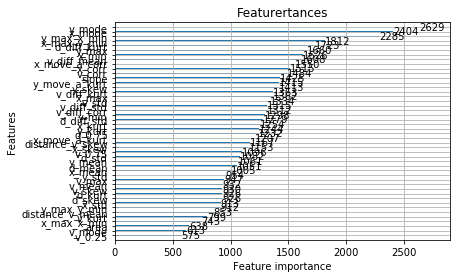

In [97]:
print(lgb_model.feature_importances_)
plt.figure(figsize=(20,10))
lgb.plot_importance(lgb_model)
plt.title("Featurertances")
plt.show()

booster = lgb_model.booster_
importance = booster.feature_importance(importance_type='split')
feature_name = booster.feature_name()
# for (feature_name,importance) in zip(feature_name,importance):
#     print (feature_name,importance) 
feature_importance = pd.DataFrame({'feature_name':feature_name,'importance':importance} )
feature_importance.to_csv('feature_importance.csv',index=False)

In [98]:
test_pred = lgb_model.predict(test_label[features])
sub = test_label[['ship']]
sub['pred'] = test_pred

print(sub['pred'].value_counts(1))
sub['pred'] = sub['pred'].map(type_map_rev)
print(sub.head())
sub.to_csv('result_a_round2.csv', index=None, header=None)

0    0.6345
1    0.2320
2    0.1335
Name: pred, dtype: float64
   ship pred
0  7000   围网
1  7001   拖网
2  7002   围网
3  7003   拖网
4  7004   围网


In [99]:
test_pred = lgb_model.predict(testB_label[features])
sub = testB_label[['ship']]
sub['pred'] = test_pred

print(sub['pred'].value_counts(1))
sub['pred'] = sub['pred'].map(type_map_rev)
print(sub.head())
sub.to_csv('result_B_round2.csv', index=None, header=None)
#0.6255,0.2355,0.1390

0    0.6275
1    0.2330
2    0.1395
Name: pred, dtype: float64
    ship pred
0  10000   围网
1  10001   拖网
2  10002   拖网
3  10003   拖网
4  10004   拖网


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier

#xgb
def xgb_model(x_train,y_train):
    print("xgb_model train")
    param1={'n_estimators':range(100,300,50)}#'learning_rate':[0.01,0.05,0.1,0.15,0.2]} #训练集上f1_macro表现： 0.8818405344222822
    param2={'min_child_weight':range(5,10,1)}#best:7
    param3={'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1.0]}#best:0.9
    param4={'scale_pos_weight':range(1,8,1)}#best:1
    
    model_test=XGBClassifier(learning_rate=0.1,n_estimators=250,max_depth=7,gamma=0,eval_metric='mlogloss')
    model_test.fit(x_train,y_train)
    
    #首先对n_estimators进行网格搜索  
    gsearch1= GridSearchCV(estimator = model_test, param_grid =param2, scoring='f1_macro',cv=7,n_jobs=-1)  
    gsearch1.fit(x_train,y_train)  
    
    print(gsearch1.best_params_) 
    print("训练集上f1_macro表现：",gsearch1.best_score_) 
    #print(model_test.feature_importances_)
  
    model=gsearch1.best_estimator_
    return model_test
                           

x_train = train_label[features].copy()
y_train = train_label[target]
xgb_model=xgb_model(x_train,y_train)
#{'n_estimators': 250} 训练集上f1_macro表现： 0.878421019503787

xgb_model train
{'min_child_weight': 6}
训练集上f1_macro表现： 0.8730653179880561


In [24]:
test_pred = xgb_model.predict(test_label[features])


#print(test_pred)
#pred = np.argmax(test_pred)
sub = test_label[['ship']]
sub['pred'] = test_pred

print(sub['pred'].value_counts(1))
sub['pred'] = sub['pred'].map(type_map_rev)
print(sub.head())
#sub.to_csv('result_new.csv', index=None, header=None)


0    0.6430
1    0.2285
2    0.1285
Name: pred, dtype: float64
   ship pred
0  7000   围网
1  7001   拖网
2  7002   围网
3  7003   拖网
4  7004   围网


In [31]:
ret = []
for index, model in enumerate(models):
    df = pd.DataFrame()
    df['name'] = model.feature_name()
    df['score'] = model.feature_importance()
    df['fold'] = index
    ret.append(df)
    
df = pd.concat(ret)

In [32]:
df = df.groupby('name', as_index=False)['score'].mean()
df = df.sort_values(['score'], ascending=False)

In [33]:
df

,name,score
32,x_mode,689.4
42,y_mode,669.0
38,y_max_x_min,638.2
29,x_max_y_min,535.8
1,corr_x,512.6
2,corr_y,508.0
21,v_skew,464.4
22,v_std,453.0
37,y_max,413.4
33,x_skew,413.0
